In [4]:
import json
import os

data = {}
dataroot = "awe"
transl_file = "awe-translation.csv"

for i in range(1,101):
    with open(os.path.join(dataroot,str(i).zfill(3),"annotations.json")) as f:
        data[str(i).zfill(3)] = json.load(f)

In [5]:
test_files = []
train_files = []

import csv
with open(transl_file) as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        if("train" in row[0]):
            train_files.append(row[1])
        elif("test" in row[0]):
            test_files.append(row[1])
            
print(len(test_files),len(train_files))
print(test_files[0])

250 750
011/07.png


In [6]:
#definition of our dataset. Returns triplets of images, two of same person and one of another

from torch.utils.data import Dataset, DataLoader
from itertools import combinations,permutations
import random
from skimage import io, color
from skimage.transform import rescale
from skimage.util import pad
from torchvision import transforms
from torchvision.transforms.functional import pad

imgsize = 128

class EarDataset(Dataset):
    """Ear dataset."""
    
    
    def __init__(self, root_dir, data, validation=False):

        #self.data = data
        #self.dataroot = root_dir
        
        self.data = []
        self.annots_gender = []
        self.annots_ethn = []
        self.annots_id = []
        
        if validation:
            filenames = test_files
        else:
            filenames = train_files
        
        for i in filenames:
            self.data.append(os.path.join(root_dir,i))
            #print(i.split("/")[0])
            with open(os.path.join(root_dir,i.split("/")[0],"annotations.json")) as f:
                annotdata = json.load(f)
            self.annots_gender.append([0 if annotdata["gender"]=="m" else 1])
            ethn = annotdata["ethnicity"]
            if ethn == 99:
                ethn = 0
            self.annots_ethn.append(ethn)
            self.annots_id.append(int(i.split("/")[0])-1)
        
        #print(len(self.data))
        #print(self.annots_gender)
        #print(len(np.unique(self.annots_id)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        image = io.imread(self.data[idx])
        annotg = self.annots_gender[idx]
        annote = self.annots_ethn[idx]
        annoti = self.annots_id[idx]

        if len(image.shape) == 2:
            image = color.gray2rgb(image)
        elif image.shape[2] == 4:
            image = image[:,:,:3]
    
        image = rescale(image,imgsize/image.shape[0],multichannel = True)
    
        return image_transform(image).type(torch.FloatTensor)[:,:,:128],annotg,annote,annoti
        
image_transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Pad((0,0,128,0))
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [7]:
import torch
import numpy as np

dataset_train = EarDataset(dataroot,data,validation=False)
dataset_loader_train = torch.utils.data.DataLoader(dataset_train,
                                             batch_size=2, shuffle=True,
                                             num_workers=4)
dataset_test = EarDataset(dataroot,data,validation=True)
dataset_loader_valid = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=16, shuffle=False,
                                             num_workers=4)

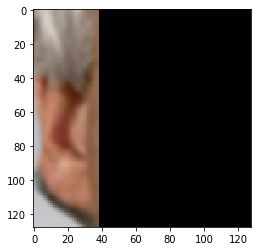

In [8]:
import matplotlib.pyplot as plt
import numpy as np

for i in dataset_loader_train:
    #print(i[0].shape)
    plt.figure()
    plt.imshow(i[0][0].permute(1,2,0))
    break

In [9]:
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

allmodels = {"resnet18":models.resnet18,"resnet34":models.resnet34,"resnet50":models.resnet50,"resnet101":models.resnet101,"alexnet":models.alexnet,"mobilenet":models.mobilenet_v2,"vgg16":models.vgg16}

class MyModel(nn.Module):
    def __init__(self, num_classes1, num_classes2, num_classes3, model="resnet50"):
        super(MyModel, self).__init__()
        self.model_resnet = allmodels[model](pretrained=True)
        
        if model in ["mobilenet"]:
            num_ftrs = self.model_resnet.classifier[1].in_features
            self.model_resnet.classifier[1] = nn.Identity()
        elif model in ["alexnet","vgg16"]:
            num_ftrs = self.model_resnet.classifier[6].in_features
            self.model_resnet.classifier[6] = nn.Identity()
        else:
            num_ftrs = self.model_resnet.fc.in_features
            self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        self.fc2 = nn.Linear(num_ftrs, num_classes2)
        self.fc3 = nn.Linear(num_ftrs, num_classes3)

    def forward(self, x):
        x = self.model_resnet(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        return out1, out2, out3

net = MyModel(2,7,100, model="resnet18")
#num_ftrs = net.fc.in_features
#net.fc = nn.Linear(num_ftrs, 2)
net.cuda()
#summary(resnet50,(3,128,60))

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [10]:
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score

losses_train = []
losses_valid = []
acc_traing = []
acc_validg = []
acc_traine = []
acc_valide = []
acc_traini = []
acc_validi = []

max_ag = 0
max_ae = 0
max_ai = 0

def train_model(model, criterion, optimizer, num_epochs=2, validation=False, savename=None):
    since = time.time()

    global max_ag, max_ae, max_ai  
    
    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:
            
            if phase == 'train':
                if validation:
                    continue
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            #print("Starting phase: ", phase)
            losses = []   
            # Iterate over data.
            
            labelsg = []
            predsg = []
            labelse = []
            predse = []
            labelsi = []
            predsi = []
            
            dataload = dataset_loader_train if phase == 'train' else dataset_loader_valid
            for stuff in dataload:
                
                image, annotg, annote, annoti = stuff
                
                image = image.cuda()
                
                #print(annotg[0].shape)
                #print(annote.shape)
                
                annotg = annotg[0].cuda()
                annote = annote.cuda()
                annoti = annoti.cuda()
                
                #print(annot)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(image)

                    #print(outputs.shape)
                    #print(annot.shape)
                    #4800
                    #assert 0
                    
                    lossg = criterion(outputs[0], annotg)
                    losse = criterion(outputs[1], annote)
                    lossi = criterion(outputs[2], annoti)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        lossg.backward(retain_graph = True)
                        losse.backward(retain_graph = True)
                        lossi.backward(retain_graph = True)
                        optimizer.step()
                    

                # statistics
                losses.append(lossg.item()+losse.item()+lossi.item()) #* images.size(0)
                
                annoti = annoti.cpu().detach().numpy()
                outputsi = np.argmax(outputs[2].cpu().detach().numpy(), axis=1)
                annotg = annotg.cpu().detach().numpy()
                outputsg = np.argmax(outputs[0].cpu().detach().numpy(), axis=1)
                annote = annote.cpu().detach().numpy()
                outputse = np.argmax(outputs[1].cpu().detach().numpy(), axis=1)
                
                labelsg.append(annotg)
                predsg.append(outputsg)
                labelse.append(annote)
                predse.append(outputse)
                labelsi.append(annoti)
                predsi.append(outputsi)
                
            epoch_loss = np.mean(losses)
            labelsg = np.concatenate(labelsg)
            predsg = np.concatenate(predsg)
            labelse = np.concatenate(labelse)
            predse = np.concatenate(predse)
            labelsi = np.concatenate(labelsi)
            predsi = np.concatenate(predsi)
            
            accg = accuracy_score(labelsg,predsg)
            acce = accuracy_score(labelse,predse)
            acci = accuracy_score(labelsi,predsi)

                     
            if(phase == 'train'):
                losses_train.append(epoch_loss)
                acc_traing.append(accg)
                acc_traine.append(acce)
                acc_traini.append(acci)
            else:
                losses_valid.append(epoch_loss)
                acc_validg.append(accg)
                acc_valide.append(acce)
                acc_validi.append(acci)
                if(accg > max_ag):
                    max_ag = accg
                if(acce > max_ae):
                    max_ae = acce
                if(acci > max_ai):
                    max_ai = acci
                    if savename is not None:
                        torch.save(model.state_dict(),savename)
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Accuracy gender {:.4f} Accuracy ethnicity {:.4f} Accuracy id {:.4f}'.format(
            #    phase, epoch_loss,accg,acce,acci))

    time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s, max accuracies achieved: gender {:.4f} ethn {:.4f} id {:.4f}'.format(
    #    time_elapsed // 60, time_elapsed % 60,max_ag, max_ae, max_ai))
    #print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [11]:
net = net.cuda()
net = train_model(net, criterion, optimizer, num_epochs=50, validation=False)

RuntimeError: Error(s) in loading state_dict for MyModel:
	Missing key(s) in state_dict: "model_resnet.conv1.weight", "model_resnet.bn1.weight", "model_resnet.bn1.bias", "model_resnet.bn1.running_mean", "model_resnet.bn1.running_var", "model_resnet.layer1.0.conv1.weight", "model_resnet.layer1.0.bn1.weight", "model_resnet.layer1.0.bn1.bias", "model_resnet.layer1.0.bn1.running_mean", "model_resnet.layer1.0.bn1.running_var", "model_resnet.layer1.0.conv2.weight", "model_resnet.layer1.0.bn2.weight", "model_resnet.layer1.0.bn2.bias", "model_resnet.layer1.0.bn2.running_mean", "model_resnet.layer1.0.bn2.running_var", "model_resnet.layer1.1.conv1.weight", "model_resnet.layer1.1.bn1.weight", "model_resnet.layer1.1.bn1.bias", "model_resnet.layer1.1.bn1.running_mean", "model_resnet.layer1.1.bn1.running_var", "model_resnet.layer1.1.conv2.weight", "model_resnet.layer1.1.bn2.weight", "model_resnet.layer1.1.bn2.bias", "model_resnet.layer1.1.bn2.running_mean", "model_resnet.layer1.1.bn2.running_var", "model_resnet.layer1.2.conv1.weight", "model_resnet.layer1.2.bn1.weight", "model_resnet.layer1.2.bn1.bias", "model_resnet.layer1.2.bn1.running_mean", "model_resnet.layer1.2.bn1.running_var", "model_resnet.layer1.2.conv2.weight", "model_resnet.layer1.2.bn2.weight", "model_resnet.layer1.2.bn2.bias", "model_resnet.layer1.2.bn2.running_mean", "model_resnet.layer1.2.bn2.running_var", "model_resnet.layer2.0.conv1.weight", "model_resnet.layer2.0.bn1.weight", "model_resnet.layer2.0.bn1.bias", "model_resnet.layer2.0.bn1.running_mean", "model_resnet.layer2.0.bn1.running_var", "model_resnet.layer2.0.conv2.weight", "model_resnet.layer2.0.bn2.weight", "model_resnet.layer2.0.bn2.bias", "model_resnet.layer2.0.bn2.running_mean", "model_resnet.layer2.0.bn2.running_var", "model_resnet.layer2.0.downsample.0.weight", "model_resnet.layer2.0.downsample.1.weight", "model_resnet.layer2.0.downsample.1.bias", "model_resnet.layer2.0.downsample.1.running_mean", "model_resnet.layer2.0.downsample.1.running_var", "model_resnet.layer2.1.conv1.weight", "model_resnet.layer2.1.bn1.weight", "model_resnet.layer2.1.bn1.bias", "model_resnet.layer2.1.bn1.running_mean", "model_resnet.layer2.1.bn1.running_var", "model_resnet.layer2.1.conv2.weight", "model_resnet.layer2.1.bn2.weight", "model_resnet.layer2.1.bn2.bias", "model_resnet.layer2.1.bn2.running_mean", "model_resnet.layer2.1.bn2.running_var", "model_resnet.layer2.2.conv1.weight", "model_resnet.layer2.2.bn1.weight", "model_resnet.layer2.2.bn1.bias", "model_resnet.layer2.2.bn1.running_mean", "model_resnet.layer2.2.bn1.running_var", "model_resnet.layer2.2.conv2.weight", "model_resnet.layer2.2.bn2.weight", "model_resnet.layer2.2.bn2.bias", "model_resnet.layer2.2.bn2.running_mean", "model_resnet.layer2.2.bn2.running_var", "model_resnet.layer2.3.conv1.weight", "model_resnet.layer2.3.bn1.weight", "model_resnet.layer2.3.bn1.bias", "model_resnet.layer2.3.bn1.running_mean", "model_resnet.layer2.3.bn1.running_var", "model_resnet.layer2.3.conv2.weight", "model_resnet.layer2.3.bn2.weight", "model_resnet.layer2.3.bn2.bias", "model_resnet.layer2.3.bn2.running_mean", "model_resnet.layer2.3.bn2.running_var", "model_resnet.layer3.0.conv1.weight", "model_resnet.layer3.0.bn1.weight", "model_resnet.layer3.0.bn1.bias", "model_resnet.layer3.0.bn1.running_mean", "model_resnet.layer3.0.bn1.running_var", "model_resnet.layer3.0.conv2.weight", "model_resnet.layer3.0.bn2.weight", "model_resnet.layer3.0.bn2.bias", "model_resnet.layer3.0.bn2.running_mean", "model_resnet.layer3.0.bn2.running_var", "model_resnet.layer3.0.downsample.0.weight", "model_resnet.layer3.0.downsample.1.weight", "model_resnet.layer3.0.downsample.1.bias", "model_resnet.layer3.0.downsample.1.running_mean", "model_resnet.layer3.0.downsample.1.running_var", "model_resnet.layer3.1.conv1.weight", "model_resnet.layer3.1.bn1.weight", "model_resnet.layer3.1.bn1.bias", "model_resnet.layer3.1.bn1.running_mean", "model_resnet.layer3.1.bn1.running_var", "model_resnet.layer3.1.conv2.weight", "model_resnet.layer3.1.bn2.weight", "model_resnet.layer3.1.bn2.bias", "model_resnet.layer3.1.bn2.running_mean", "model_resnet.layer3.1.bn2.running_var", "model_resnet.layer3.2.conv1.weight", "model_resnet.layer3.2.bn1.weight", "model_resnet.layer3.2.bn1.bias", "model_resnet.layer3.2.bn1.running_mean", "model_resnet.layer3.2.bn1.running_var", "model_resnet.layer3.2.conv2.weight", "model_resnet.layer3.2.bn2.weight", "model_resnet.layer3.2.bn2.bias", "model_resnet.layer3.2.bn2.running_mean", "model_resnet.layer3.2.bn2.running_var", "model_resnet.layer3.3.conv1.weight", "model_resnet.layer3.3.bn1.weight", "model_resnet.layer3.3.bn1.bias", "model_resnet.layer3.3.bn1.running_mean", "model_resnet.layer3.3.bn1.running_var", "model_resnet.layer3.3.conv2.weight", "model_resnet.layer3.3.bn2.weight", "model_resnet.layer3.3.bn2.bias", "model_resnet.layer3.3.bn2.running_mean", "model_resnet.layer3.3.bn2.running_var", "model_resnet.layer3.4.conv1.weight", "model_resnet.layer3.4.bn1.weight", "model_resnet.layer3.4.bn1.bias", "model_resnet.layer3.4.bn1.running_mean", "model_resnet.layer3.4.bn1.running_var", "model_resnet.layer3.4.conv2.weight", "model_resnet.layer3.4.bn2.weight", "model_resnet.layer3.4.bn2.bias", "model_resnet.layer3.4.bn2.running_mean", "model_resnet.layer3.4.bn2.running_var", "model_resnet.layer3.5.conv1.weight", "model_resnet.layer3.5.bn1.weight", "model_resnet.layer3.5.bn1.bias", "model_resnet.layer3.5.bn1.running_mean", "model_resnet.layer3.5.bn1.running_var", "model_resnet.layer3.5.conv2.weight", "model_resnet.layer3.5.bn2.weight", "model_resnet.layer3.5.bn2.bias", "model_resnet.layer3.5.bn2.running_mean", "model_resnet.layer3.5.bn2.running_var", "model_resnet.layer4.0.conv1.weight", "model_resnet.layer4.0.bn1.weight", "model_resnet.layer4.0.bn1.bias", "model_resnet.layer4.0.bn1.running_mean", "model_resnet.layer4.0.bn1.running_var", "model_resnet.layer4.0.conv2.weight", "model_resnet.layer4.0.bn2.weight", "model_resnet.layer4.0.bn2.bias", "model_resnet.layer4.0.bn2.running_mean", "model_resnet.layer4.0.bn2.running_var", "model_resnet.layer4.0.downsample.0.weight", "model_resnet.layer4.0.downsample.1.weight", "model_resnet.layer4.0.downsample.1.bias", "model_resnet.layer4.0.downsample.1.running_mean", "model_resnet.layer4.0.downsample.1.running_var", "model_resnet.layer4.1.conv1.weight", "model_resnet.layer4.1.bn1.weight", "model_resnet.layer4.1.bn1.bias", "model_resnet.layer4.1.bn1.running_mean", "model_resnet.layer4.1.bn1.running_var", "model_resnet.layer4.1.conv2.weight", "model_resnet.layer4.1.bn2.weight", "model_resnet.layer4.1.bn2.bias", "model_resnet.layer4.1.bn2.running_mean", "model_resnet.layer4.1.bn2.running_var", "model_resnet.layer4.2.conv1.weight", "model_resnet.layer4.2.bn1.weight", "model_resnet.layer4.2.bn1.bias", "model_resnet.layer4.2.bn1.running_mean", "model_resnet.layer4.2.bn1.running_var", "model_resnet.layer4.2.conv2.weight", "model_resnet.layer4.2.bn2.weight", "model_resnet.layer4.2.bn2.bias", "model_resnet.layer4.2.bn2.running_mean", "model_resnet.layer4.2.bn2.running_var", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "fc.weight", "fc.bias". 

0


MyModel(
  (model_resnet): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

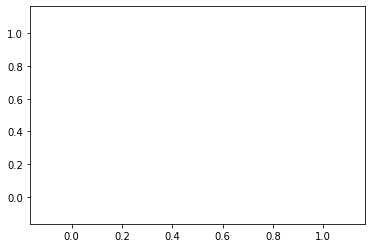

In [24]:
from torchsummary import summary

print(max_ag)
plt.plot(acc_validi)
plt.plot(acc_validg)
plt.plot(acc_valide)
#plt.plot(acc_traini)
net = models.vgg16(pretrained=True).cuda()
net = MyModel(2,7,100,"vgg16").cuda()
net

vgg16 32
{'acci': 0.396, 'accg': 0.988, 'acce': 0.812, 'model': 'vgg16', 'batchsize': 32}
best model: {'acci': 0, 'accg': 0, 'acce': 0, 'model': 'none', 'batchsize': 0}
[{'acci': 0.396, 'accg': 0.988, 'acce': 0.812, 'model': 'vgg16', 'batchsize': 32}]


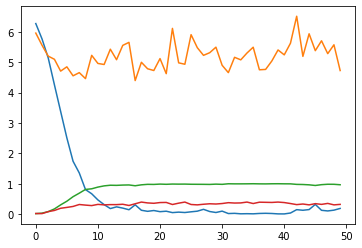

In [9]:
absolute_max = {"acci":0,"accg":0,"acce":0,"model":"none","batchsize":0}

results = []

torch.cuda.empty_cache()

for model in ["vgg16"]:
    for batchsize in [32]:
        print(model,batchsize)
        
        name = "models/model_{}_{}.pth".format(model,batchsize)
        
        losses_train = []
        losses_valid = []
        acc_traing = []
        acc_validg = []
        acc_traine = []
        acc_valide = []
        acc_traini = []
        acc_validi = []

        max_ag = 0
        max_ae = 0
        max_ai = 0
        
        net = MyModel(2,7,100, model=model)
        net.cuda()

        criterion = nn.CrossEntropyLoss().cuda()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
        
        dataset_loader_train = torch.utils.data.DataLoader(dataset_train,
                                             batch_size=batchsize, shuffle=True,
                                             num_workers=4)
        
        net = train_model(net, criterion, optimizer, num_epochs=50, validation=False, savename=name)
        
        result = {"acci":max_ai,"accg":max_ag,"acce":max_ae,"model":model,"batchsize":batchsize}
        results.append(result)
        print(result)
        
        plt.figure()
        plt.plot(losses_train)
        plt.plot(losses_valid)
        plt.plot(acc_traini)
        plt.plot(acc_validi)
        
        #if(absolute_max["acci"]<max_ai):
        #    absolute_max = result

print("best model:",absolute_max)
print(results)
        

In [27]:
dataload = dataset_loader_valid
for stuff in tqdm(dataload):
    print(stuff[0].shape)
    with torch.no_grad():
        out = net(stuff[0].cuda())
        print(out)
    break

  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 3, 128, 128])
(tensor([[ 3.3807, -3.9447],
        [ 6.0351, -6.0492],
        [ 4.8355, -5.3982],
        [ 5.7547, -6.4708],
        [ 7.7164, -8.8459],
        [ 5.2949, -6.4424],
        [ 3.7895, -4.3963],
        [ 6.4280, -7.4985],
        [ 4.5860, -5.5328],
        [ 4.5100, -5.7888],
        [ 4.5178, -4.9593],
        [ 1.6083, -2.1538],
        [ 2.5555, -2.8703],
        [ 5.7592, -6.1178],
        [ 0.7263, -1.5170],
        [ 1.0410, -1.5055]], device='cuda:0'), tensor([[ -8.7388,   0.3377,   0.0897,  -2.7267,  -4.3034,  -8.6973,  -6.7565],
        [ -3.0342,  -5.5665,   4.2643,  -3.1493,  -2.1847,  -3.8301,  -7.8876],
        [ -2.0109,  -5.4512,   5.0299,  -4.1172,  -4.5601,  -6.5722,  -6.2228],
        [-12.2948,  -5.5446,  -0.2947,  -7.1140,  -6.4498,   4.6490,  -2.7566],
        [-10.6879,  -1.2180,   0.5462,  -4.5538,  -5.9192,  -5.1829,  -7.8638],
        [ -9.6343,   4.2207,  -2.9719,  -4.7382,  -3.2221,  -8.1814,  -7.9386],
        [ -8.8669,   4

In [19]:
#np.save("results.npy",results_all,allow_pickle=True)

In [11]:
results = np.load("results.npy", allow_pickle=True)

In [13]:
for r in results:
    print(r)

{'acci': 0.56, 'accg': 0.984, 'acce': 0.848, 'model': 'resnet18', 'batchsize': 2}
{'acci': 0.504, 'accg': 0.98, 'acce': 0.856, 'model': 'resnet18', 'batchsize': 4}
{'acci': 0.472, 'accg': 0.988, 'acce': 0.812, 'model': 'resnet18', 'batchsize': 8}
{'acci': 0.348, 'accg': 0.98, 'acce': 0.772, 'model': 'resnet18', 'batchsize': 16}
{'acci': 0.584, 'accg': 0.988, 'acce': 0.852, 'model': 'resnet34', 'batchsize': 2}
{'acci': 0.5, 'accg': 0.996, 'acce': 0.844, 'model': 'resnet34', 'batchsize': 4}
{'acci': 0.488, 'accg': 0.992, 'acce': 0.84, 'model': 'resnet34', 'batchsize': 8}
{'acci': 0.444, 'accg': 0.992, 'acce': 0.82, 'model': 'resnet34', 'batchsize': 16}
{'acci': 0.492, 'accg': 0.98, 'acce': 0.812, 'model': 'resnet50', 'batchsize': 2}
{'acci': 0.524, 'accg': 0.992, 'acce': 0.836, 'model': 'resnet50', 'batchsize': 4}
{'acci': 0.476, 'accg': 0.988, 'acce': 0.828, 'model': 'resnet50', 'batchsize': 8}
{'acci': 0.416, 'accg': 0.984, 'acce': 0.816, 'model': 'resnet50', 'batchsize': 16}
{'acci': 